In [1]:
# Import TF and check for GPU

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

# Import required libraries

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import save_model, load_model
import math
from sklearn.model_selection import train_test_split
import sys
import random 

2023-09-22 16:12:18.053786: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 16:12:18.975423: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/abraham/miniconda3/envs/tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.12.1


In [2]:
tf.keras.backend.clear_session()

test Set: No. of LC = No. of shapes
Extended the light curves


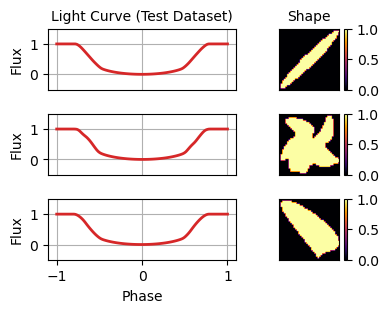

In [3]:
# Load Test Dataset
test_shape_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/shape_npy/shape_filled8.npy'
test_lc_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/lc_npy/lc_dict_8.npy'
test_lc = np.load(test_lc_dir)
test_shape = np.load(test_shape_dir)
# Check equality of number of dataset
if len(test_lc)==len(test_shape):
    print("test Set: No. of LC = No. of shapes")
else:
    sys.exit("EXIT: testn Set: No. of LC != No. of shapes")

# Normalize the image, convert to opacity map
## Test Set
test_shape = test_shape/np.amax(test_shape)
test_shape_where_0 = np.where(test_shape == 0)
test_shape_where_1 = np.where(test_shape == 1)
test_shape[test_shape_where_0] = 1  # 1 represent the shape (1 opacity)
test_shape[test_shape_where_1] = 0  # 0 represent background (0 opacity)


# Normalize the lightcurves
## - Test Set
test_lc_scaled = np.zeros(test_lc.shape)
for i in np.arange(len(test_lc_scaled)):
    test_lc_scaled[i] = (test_lc[i] - np.amin(test_lc[i]))/(np.amax(test_lc[i]) - np.amin(test_lc[i]))

# Append with ones
## - Test Set
test_lc_scaled_append = np.ones((test_lc.shape[0],120))
for i in np.arange(len(test_lc_scaled)):
    test_lc_scaled_append[i,10:110] = test_lc_scaled[i]
print("Extended the light curves")

# Verification
# Plot - Test LCs
num = 3
fig,ax=plt.subplots(num,2, figsize=(4,3), gridspec_kw={ 'width_ratios': [2,1],
        'wspace': 0.2,'hspace': 0.4})
plt.rcParams['figure.dpi'] = 400

ax[0][1].set_title('Shape',size=10)
ax[0][0].set_title('Light Curve (Test Dataset)',size=10)
ax[num-1][0].set_xlabel('Phase',size=10)
ph = np.linspace(-1,1,len(test_lc_scaled_append[0]))
# advance = 60

i = 0
for i in np.arange(0,num):
    k = random.randint(0, len(test_lc_scaled_append)-1)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(test_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=10)
    ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].plot(ph,test_lc_scaled_append[k],color = 'tab:red',linewidth='2')
    ax[i][0].grid('on')
    i = i + 1


In [4]:
# Function to Add noise to Test light curve
def add_noise(test_lc_scaled_append,SNR):
    std_dev = 1/SNR
    test_lc_scaled_append_noise = np.ones(test_lc_scaled_append.shape)
    rng = np.random.default_rng()

    for i in np.arange(len(test_lc_scaled_append)):
        noise_temp = np.random.normal(loc=0.0, scale=std_dev, size=len(test_lc_scaled_append[i]))
        rng.shuffle(noise_temp)
        test_lc_scaled_append_noise[i] = test_lc_scaled_append[i] + noise_temp
    return test_lc_scaled_append_noise


In [5]:
# Add noise to the light curve
test_lc_SNR500 =add_noise(test_lc_scaled_append,SNR=500)
test_lc_SNR200 =add_noise(test_lc_scaled_append,SNR=200)
test_lc_SNR150 =add_noise(test_lc_scaled_append,SNR=150)
test_lc_SNR100 =add_noise(test_lc_scaled_append,SNR=100)
test_lc_SNR75 =add_noise(test_lc_scaled_append,SNR=75)
test_lc_SNR50 =add_noise(test_lc_scaled_append,SNR=50)
test_lc_SNR35 =add_noise(test_lc_scaled_append,SNR=35)
test_lc_SNR20 =add_noise(test_lc_scaled_append,SNR=20)


In [6]:
# # Function to normalize predicted shape
# def normalize_shape(test_predict_shape):
#     test_predict_shape_normalized = np.zeros(test_predict_shape.shape)
#     for i in np.arange(len(test_predict_shape)):
#         test_predict_shape_normalized[i] = (test_predict_shape[i] - np.amin(test_predict_shape[i]))/(np.amax(test_predict_shape[i]) - np.amin(test_predict_shape[i]))
#     print("Normalized the predicted shape")
#     return test_predict_shape_normalized

# #Load ML model
# tf.keras.backend.clear_session()

# model_SNR = load_model("ml_saved_models/model_sep20_SNR_500_v1/model_sep20_SNR_500_v1.h5")
# results = model_SNR.evaluate(test_lc_SNR500, test_shape, batch_size=128)
# print("SNR = 500. Loss ->",results)
# test_predict_shape_SNR500 = model_SNR.predict(test_lc_SNR500)
# test_predict_shape_SNR500 = normalize_shape(test_predict_shape_SNR500)
# tf.keras.backend.clear_session()
# del model_SNR

# model_SNR = load_model("ml_saved_models/model_sep20_SNR_200_v1/model_sep20_SNR_200_v1.h5")
# results = model_SNR.evaluate(test_lc_SNR200, test_shape, batch_size=128)
# print("SNR = 200. Loss ->",results)
# test_predict_shape_SNR200 = model_SNR.predict(test_lc_SNR200)
# test_predict_shape_SNR200 = normalize_shape(test_predict_shape_SNR200)
# tf.keras.backend.clear_session()
# del model_SNR

# model_SNR = load_model("ml_saved_models/model_sep20_SNR_150_v1/model_sep20_SNR_150_v1.h5")
# results = model_SNR.evaluate(test_lc_SNR150, test_shape, batch_size=128)
# print("SNR = 150. Loss ->",results)
# test_predict_shape_SNR150 = model_SNR.predict(test_lc_SNR150)
# test_predict_shape_SNR150 = normalize_shape(test_predict_shape_SNR150)
# tf.keras.backend.clear_session()
# del model_SNR

# model_SNR = load_model("ml_saved_models/model_sep20_SNR_100_v1/model_sep20_SNR_100_v1.h5")
# results = model_SNR.evaluate(test_lc_SNR100, test_shape, batch_size=128)
# print("SNR = 100. Loss ->",results)
# test_predict_shape_SNR100 = model_SNR.predict(test_lc_SNR100)
# test_predict_shape_SNR100 = normalize_shape(test_predict_shape_SNR100)
# tf.keras.backend.clear_session()
# del model_SNR

# model_SNR = load_model("ml_saved_models/model_sep20_SNR_75_v1/model_sep20_SNR_75_v1.h5")
# results = model_SNR.evaluate(test_lc_SNR75, test_shape, batch_size=128)
# print("SNR = 75. Loss ->",results)
# test_predict_shape_SNR75 = model_SNR.predict(test_lc_SNR75)
# test_predict_shape_SNR75 = normalize_shape(test_predict_shape_SNR75)
# tf.keras.backend.clear_session()
# del model_SNR

# model_SNR = load_model("ml_saved_models/model_sep20_SNR_50_v1/model_sep20_SNR_50_v1.h5")
# results = model_SNR.evaluate(test_lc_SNR50, test_shape, batch_size=128)
# print("SNR = 50. Loss ->",results)
# test_predict_shape_SNR50 = model_SNR.predict(test_lc_SNR50)
# test_predict_shape_SNR50 = normalize_shape(test_predict_shape_SNR50)
# tf.keras.backend.clear_session()
# del model_SNR

# model_SNR = load_model("ml_saved_models/model_sep20_SNR_35_v1/model_sep20_SNR_35_v1.h5")
# results = model_SNR.evaluate(test_lc_SNR35, test_shape, batch_size=128)
# print("SNR = 35. Loss ->",results)
# test_predict_shape_SNR35 = model_SNR.predict(test_lc_SNR35)
# test_predict_shape_SNR35 = normalize_shape(test_predict_shape_SNR35)
# tf.keras.backend.clear_session()
# del model_SNR

# model_SNR = load_model("ml_saved_models/model_sep20_SNR_20_v1/model_sep20_SNR_20_v1.h5")
# results = model_SNR.evaluate(test_lc_SNR20, test_shape, batch_size=128)
# print("SNR = 20. Loss ->",results)
# test_predict_shape_SNR20 = model_SNR.predict(test_lc_SNR20)
# test_predict_shape_SNR20 = normalize_shape(test_predict_shape_SNR20)
# tf.keras.backend.clear_session()
# del model_SNR

In [7]:
# Experiment 2
# Switch on one MODEL and test on LC with different SNR
# Function to normalize predicted shape
def normalize_shape(test_predict_shape):
    test_predict_shape_normalized = np.zeros(test_predict_shape.shape)
    for i in np.arange(len(test_predict_shape)):
        test_predict_shape_normalized[i] = (test_predict_shape[i] - np.amin(test_predict_shape[i]))/(np.amax(test_predict_shape[i]) - np.amin(test_predict_shape[i]))
    print("Normalized the predicted shape")
    return test_predict_shape_normalized

#Load ML model
tf.keras.backend.clear_session()
model_SNR = load_model("ml_saved_models/model_sep22_unf_50_500_v1/model_sep22_unf_50_500_v1.h5")

results = model_SNR.evaluate(test_lc_SNR500, test_shape, batch_size=128)
print("SNR = 500. Loss ->",results)
test_predict_shape_SNR500 = model_SNR.predict(test_lc_SNR500)
test_predict_shape_SNR500 = normalize_shape(test_predict_shape_SNR500)

results = model_SNR.evaluate(test_lc_SNR200, test_shape, batch_size=128)
print("SNR = 200. Loss ->",results)
test_predict_shape_SNR200 = model_SNR.predict(test_lc_SNR200)
test_predict_shape_SNR200 = normalize_shape(test_predict_shape_SNR200)

results = model_SNR.evaluate(test_lc_SNR150, test_shape, batch_size=128)
print("SNR = 150. Loss ->",results)
test_predict_shape_SNR150 = model_SNR.predict(test_lc_SNR150)
test_predict_shape_SNR150 = normalize_shape(test_predict_shape_SNR150)

results = model_SNR.evaluate(test_lc_SNR100, test_shape, batch_size=128)
print("SNR = 100. Loss ->",results)
test_predict_shape_SNR100 = model_SNR.predict(test_lc_SNR100)
test_predict_shape_SNR100 = normalize_shape(test_predict_shape_SNR100)

results = model_SNR.evaluate(test_lc_SNR75, test_shape, batch_size=128)
print("SNR = 75. Loss ->",results)
test_predict_shape_SNR75 = model_SNR.predict(test_lc_SNR75)
test_predict_shape_SNR75 = normalize_shape(test_predict_shape_SNR75)

results = model_SNR.evaluate(test_lc_SNR50, test_shape, batch_size=128)
print("SNR = 50. Loss ->",results)
test_predict_shape_SNR50 = model_SNR.predict(test_lc_SNR50)
test_predict_shape_SNR50 = normalize_shape(test_predict_shape_SNR50)

results = model_SNR.evaluate(test_lc_SNR35, test_shape, batch_size=128)
print("SNR = 35. Loss ->",results)
test_predict_shape_SNR35 = model_SNR.predict(test_lc_SNR35)
test_predict_shape_SNR35 = normalize_shape(test_predict_shape_SNR35)

results = model_SNR.evaluate(test_lc_SNR20, test_shape, batch_size=128)
print("SNR = 20. Loss ->",results)
test_predict_shape_SNR20 = model_SNR.predict(test_lc_SNR20)
test_predict_shape_SNR20 = normalize_shape(test_predict_shape_SNR20)


2023-09-22 16:12:23.085328: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15550 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2023-09-22 16:12:25.385143: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


2/2 [==============================] - 3s 243ms/step - loss: 0.1106
SNR = 500. Loss -> 0.11062632501125336
8/8 [==============================] - 1s 29ms/step
Normalized the predicted shape
2/2 [==============================] - 0s 9ms/step - loss: 0.1202
SNR = 200. Loss -> 0.12017133831977844
8/8 [==============================] - 0s 6ms/step
Normalized the predicted shape
2/2 [==============================] - 0s 12ms/step - loss: 0.1237
SNR = 150. Loss -> 0.12372104823589325
8/8 [==============================] - 0s 4ms/step
Normalized the predicted shape
2/2 [==============================] - 0s 11ms/step - loss: 0.1330
SNR = 100. Loss -> 0.1329633891582489
8/8 [==============================] - 0s 6ms/step
Normalized the predicted shape
2/2 [==============================] - 0s 8ms/step - loss: 0.1367
SNR = 75. Loss -> 0.13669338822364807
8/8 [==============================] - 0s 6ms/step
Normalized the predicted shape
2/2 [==============================] - 0s 9ms/step - loss: 0.1

In [8]:
temp = np.linspace(0, len(test_lc_scaled_append)-1,len(test_lc_scaled_append))
temp

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

k =  74
k =  180
k =  55
k =  56
k =  99


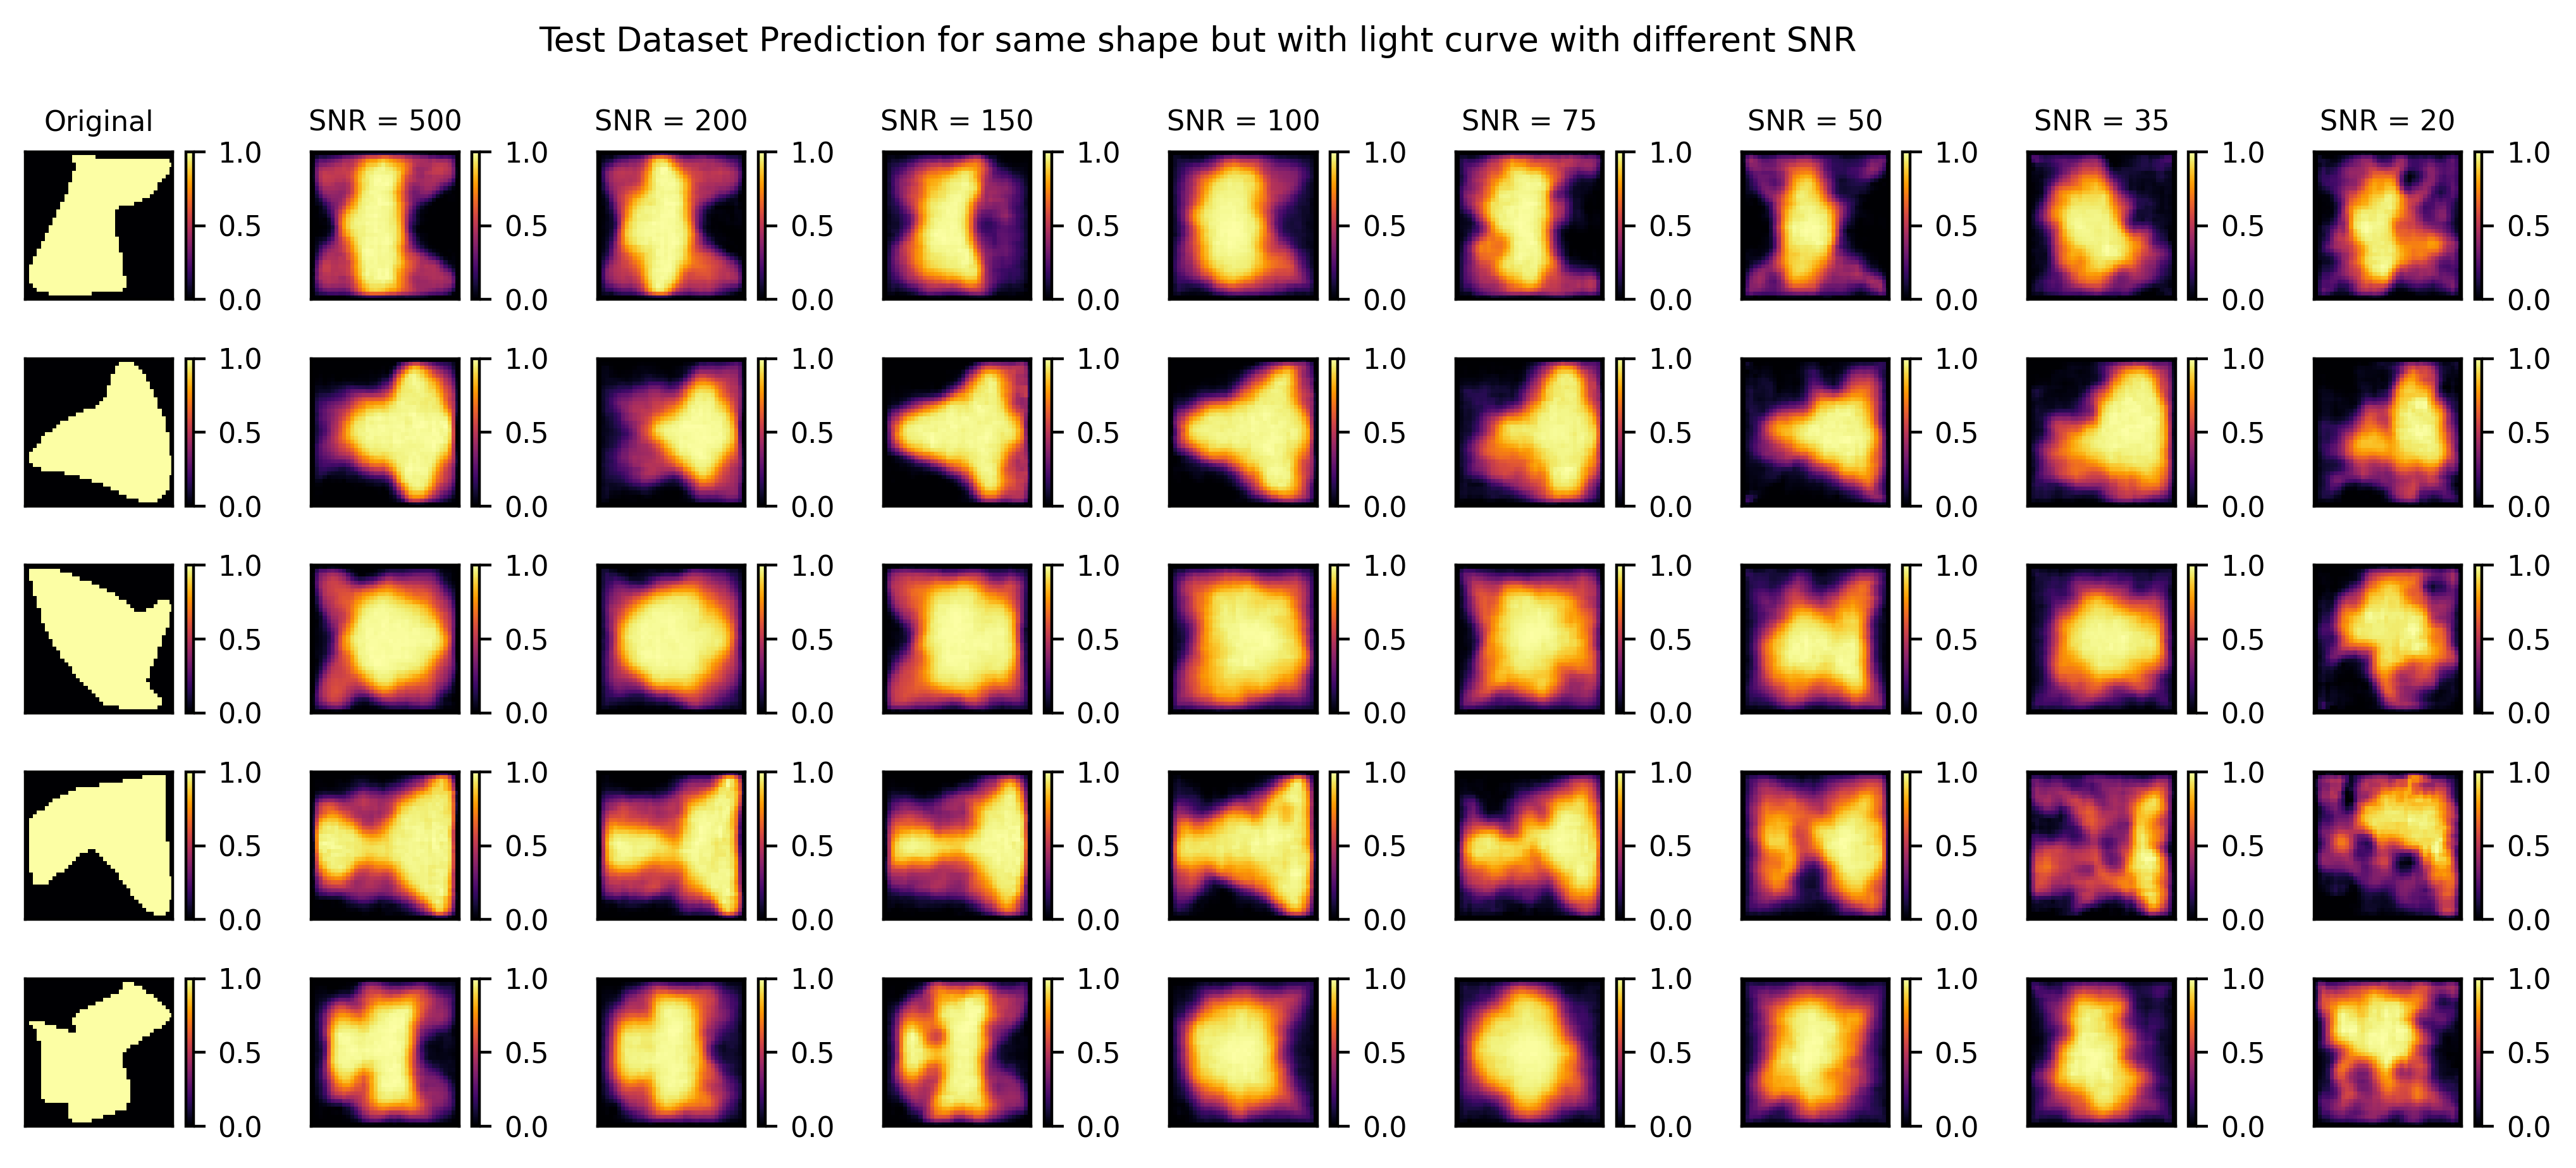

In [9]:
# Plot predicted shapes
num = 5
fig,ax=plt.subplots(num,9, figsize=(13,5), gridspec_kw={ 'width_ratios': [1,1,1,1,1,1,1,1,1],
        'wspace': 0.1,'hspace': 0.4})
plt.rcParams['figure.dpi'] = 1000
plt.rcParams.update({'font.size': 8})

ax[0][0].set_title('Original',size=8)
ax[0][1].set_title('SNR = 500',size=8)
ax[0][2].set_title('SNR = 200',size=8)
ax[0][3].set_title('SNR = 150',size=8)
ax[0][4].set_title('SNR = 100',size=8)
ax[0][5].set_title('SNR = 75',size=8)
ax[0][6].set_title('SNR = 50',size=8)
ax[0][7].set_title('SNR = 35',size=8)
ax[0][8].set_title('SNR = 20',size=8)


temp = np.linspace(0, len(test_lc_scaled_append)-1,len(test_lc_scaled_append))
index_test_array = np.random.choice(temp, size=(num,), replace=False)

for i in range(num):
    k =  int(index_test_array[i]) # random.randint(0, len(test_lc_scaled_append)-1) # i
    print("k = ",k)
    ax[i][0].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][3].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][4].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][5].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][6].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][7].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][8].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)


    img = ax[i][0].imshow(test_shape[k],cmap='inferno')
    plt.colorbar(img)  

    img = ax[i][1].imshow(test_predict_shape_SNR500[k],cmap='inferno')
    plt.colorbar(img)   

    img = ax[i][2].imshow(test_predict_shape_SNR200[k],cmap='inferno')
    plt.colorbar(img)   

    img = ax[i][3].imshow(test_predict_shape_SNR150[k],cmap='inferno')
    plt.colorbar(img)     

    img = ax[i][4].imshow(test_predict_shape_SNR100[k],cmap='inferno')
    plt.colorbar(img)  

    img = ax[i][5].imshow(test_predict_shape_SNR75[k],cmap='inferno')
    plt.colorbar(img)     

    img = ax[i][6].imshow(test_predict_shape_SNR50[k],cmap='inferno')
    plt.colorbar(img)

    img = ax[i][7].imshow(test_predict_shape_SNR35[k],cmap='inferno')
    plt.colorbar(img)

    img = ax[i][8].imshow(test_predict_shape_SNR20[k],cmap='inferno')
    plt.colorbar(img)

plt.suptitle('Test Dataset Prediction for same shape but with light curve with different SNR')
plt.show()

k =  21
k =  35
k =  20
k =  158
k =  80


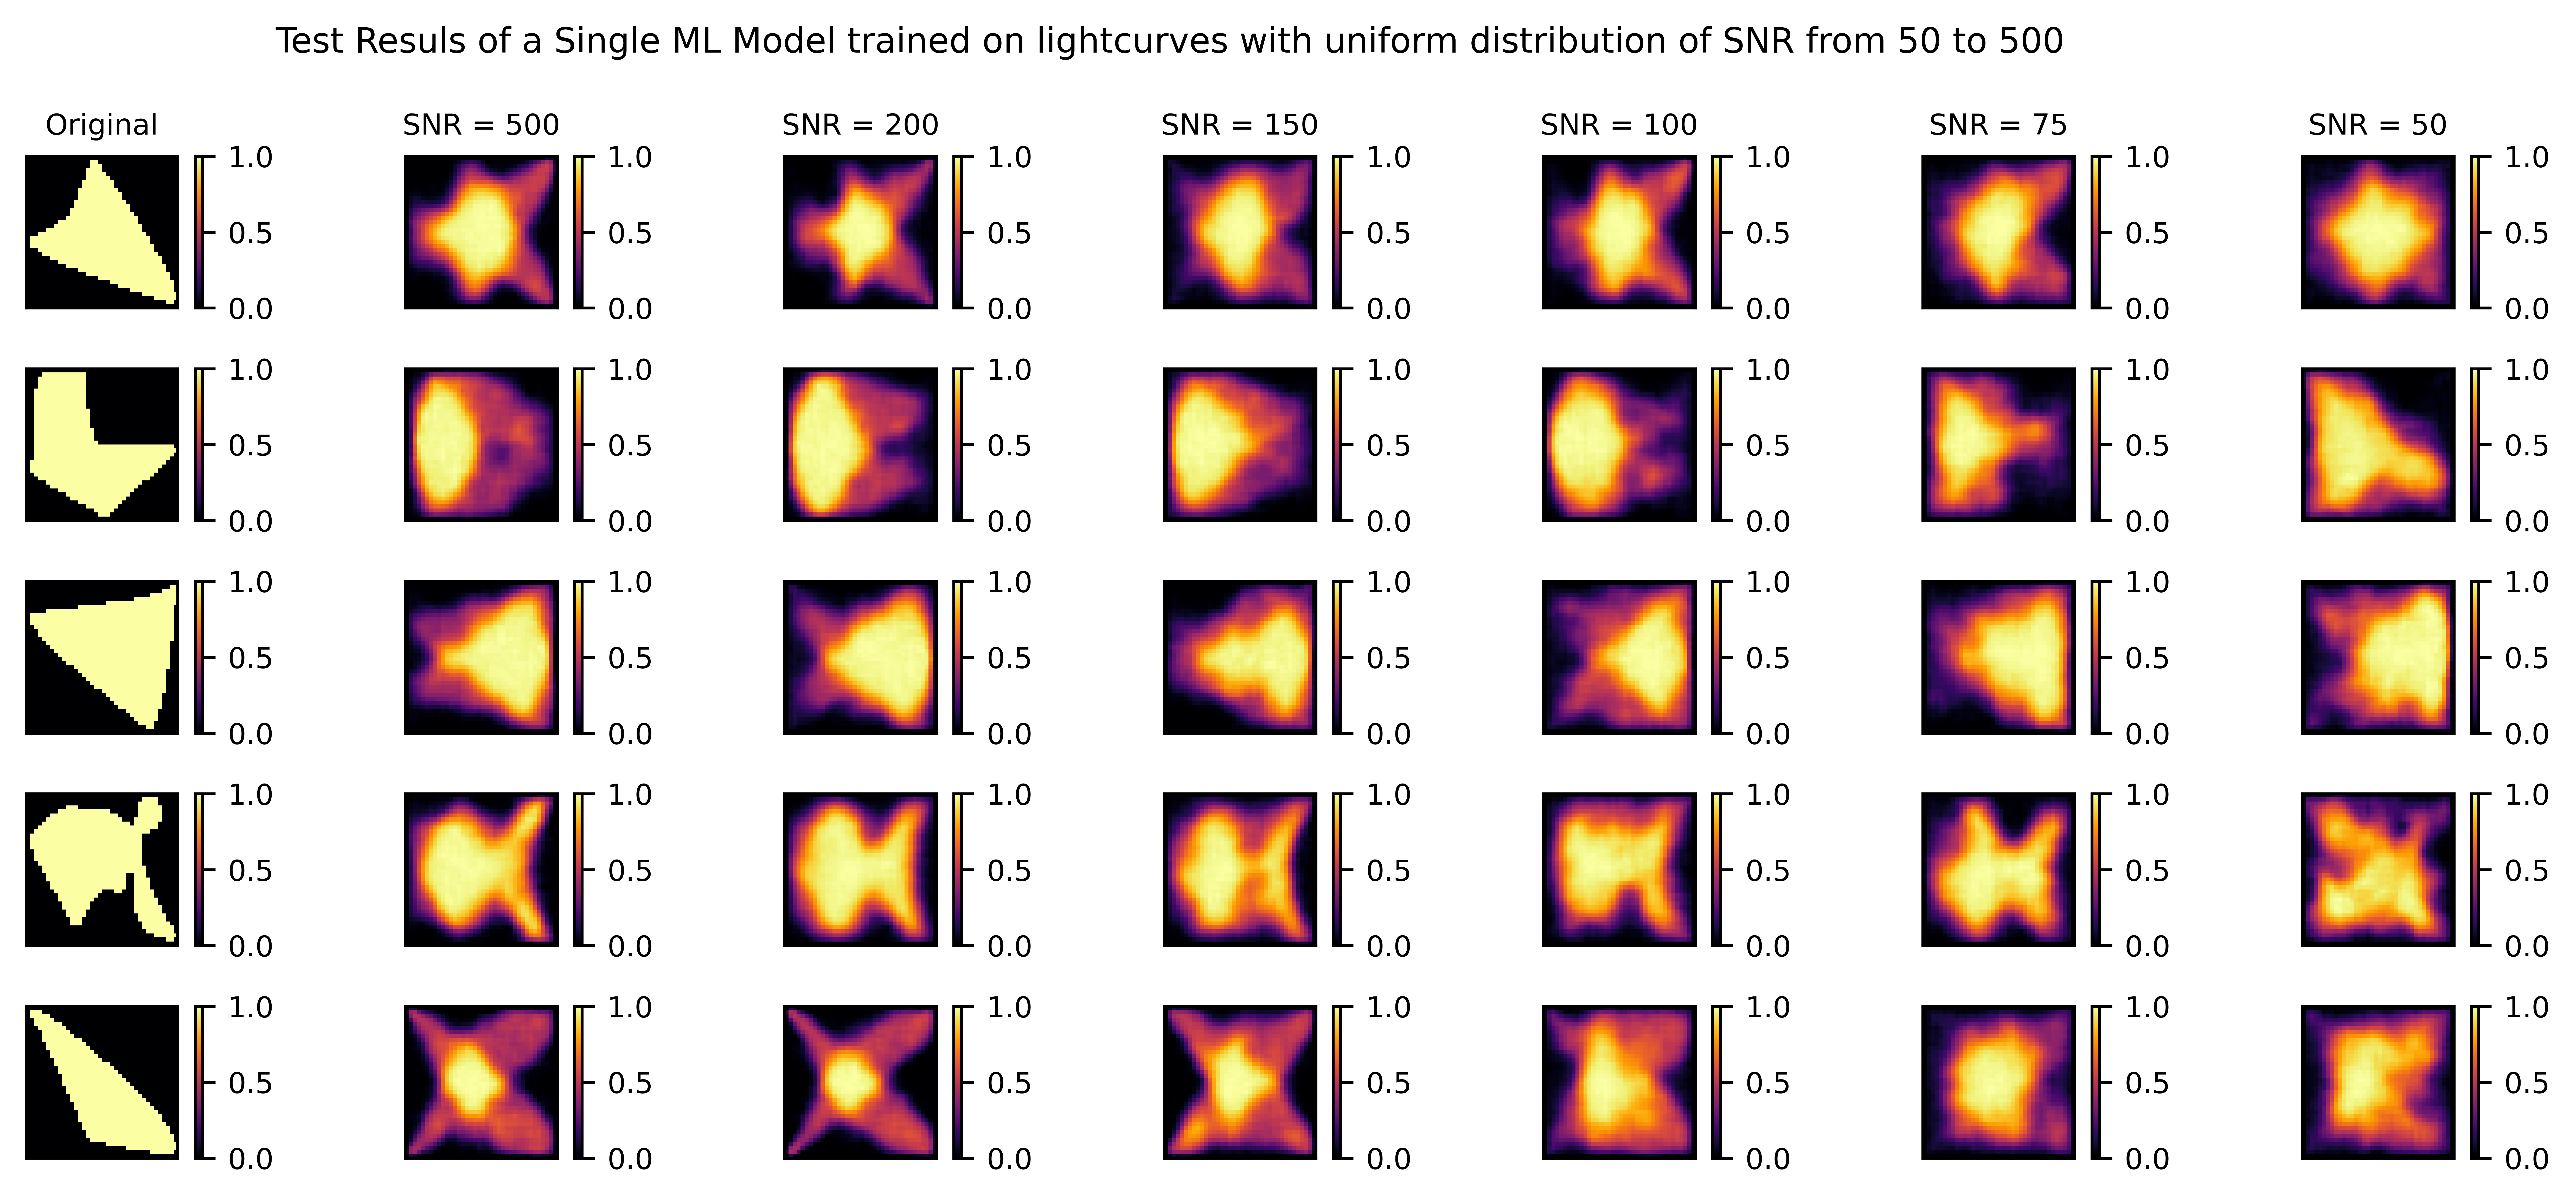

In [10]:
# Plot predicted shapes
num = 5
fig,ax=plt.subplots(num,7, figsize=(13,5), gridspec_kw={ 'width_ratios': [1,1,1,1,1,1,1],
        'wspace': 0.1,'hspace': 0.4})
plt.rcParams['figure.dpi'] = 1000
plt.rcParams.update({'font.size': 8})

ax[0][0].set_title('Original',size=8)
ax[0][1].set_title('SNR = 500',size=8)
ax[0][2].set_title('SNR = 200',size=8)
ax[0][3].set_title('SNR = 150',size=8)
ax[0][4].set_title('SNR = 100',size=8)
ax[0][5].set_title('SNR = 75',size=8)
ax[0][6].set_title('SNR = 50',size=8)



temp = np.linspace(0, len(test_lc_scaled_append)-1,len(test_lc_scaled_append))
index_test_array = np.random.choice(temp, size=(num,), replace=False)

for i in range(num):
    k =  int(index_test_array[i]) # random.randint(0, len(test_lc_scaled_append)-1) # i
    print("k = ",k)
    ax[i][0].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][3].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][4].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][5].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][6].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)


    img = ax[i][0].imshow(test_shape[k],cmap='inferno')
    plt.colorbar(img)  

    img = ax[i][1].imshow(test_predict_shape_SNR500[k],cmap='inferno')
    plt.colorbar(img)   

    img = ax[i][2].imshow(test_predict_shape_SNR200[k],cmap='inferno')
    plt.colorbar(img)   

    img = ax[i][3].imshow(test_predict_shape_SNR150[k],cmap='inferno')
    plt.colorbar(img)     

    img = ax[i][4].imshow(test_predict_shape_SNR100[k],cmap='inferno')
    plt.colorbar(img)  

    img = ax[i][5].imshow(test_predict_shape_SNR75[k],cmap='inferno')
    plt.colorbar(img)     

    img = ax[i][6].imshow(test_predict_shape_SNR50[k],cmap='inferno')
    plt.colorbar(img)

plt.suptitle('Test Resuls of a Single ML Model trained on lightcurves with uniform distribution of SNR from 50 to 500')
plt.show()

In [11]:
# Plot predicted shapes
num = 5
fig,ax=plt.subplots(num,13, figsize=(26,8), gridspec_kw={'width_ratios': [1,2,1,2,1,2,1,2,1,2,1,2,1],
        'wspace': 0.1,'hspace': 0.4})
plt.rcParams['figure.dpi'] = 1000
plt.rcParams.update({'font.size': 8})

ax[0][0].set_title('Original',size=18)
ax[0][1].set_title('SNR = 500',size=18)
ax[0][2].set_title('SNR = 500',size=18)
ax[0][3].set_title('SNR = 200',size=18)
ax[0][4].set_title('SNR = 200',size=18)
ax[0][5].set_title('SNR = 150',size=18)
ax[0][6].set_title('SNR = 150',size=18)
ax[0][7].set_title('SNR = 100',size=18)
ax[0][8].set_title('SNR = 100',size=18)
ax[0][9].set_title('SNR = 75',size=18)
ax[0][10].set_title('SNR = 75',size=18)
ax[0][11].set_title('SNR = 50',size=18)
ax[0][12].set_title('SNR = 50',size=18)

temp = np.linspace(0, len(test_lc_scaled_append)-1,len(test_lc_scaled_append))
index_test_array = np.random.choice(temp, size=(num,), replace=False)

for i in range(num):
    k =  int(index_test_array[i]) # random.randint(0, len(test_lc_scaled_append)-1) # i
    print("k = ",k)
    ax[i][0].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][3].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][4].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][5].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][6].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][7].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][8].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][9].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][10].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][11].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][12].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)

    img = ax[i][0].imshow(test_shape[k],cmap='inferno')
    # plt.colorbar(img)  

    ax[i][1].plot(ph, test_lc_SNR500[k],color = 'tab:red',linewidth='2')
    ax[i][1].grid('on')

    img = ax[i][2].imshow(test_predict_shape_SNR500[k],cmap='inferno')
    # plt.colorbar(img)  

    ax[i][3].plot(ph, test_lc_SNR200[k],color = 'tab:red',linewidth='2')
    ax[i][3].grid('on')

    img = ax[i][4].imshow(test_predict_shape_SNR200[k],cmap='inferno')
    # plt.colorbar(img)   

    ax[i][5].plot(ph, test_lc_SNR150[k],color = 'tab:red',linewidth='2')
    ax[i][5].grid('on')

    img = ax[i][6].imshow(test_predict_shape_SNR150[k],cmap='inferno')
    # plt.colorbar(img)    


    ax[i][7].plot(ph, test_lc_SNR100[k],color = 'tab:red',linewidth='2')
    ax[i][7].grid('on')

    img = ax[i][8].imshow(test_predict_shape_SNR100[k],cmap='inferno')
    # plt.colorbar(img)  

    ax[i][9].plot(ph, test_lc_SNR75[k],color = 'tab:red',linewidth='2')
    ax[i][9].grid('on')

    img = ax[i][10].imshow(test_predict_shape_SNR75[k],cmap='inferno')
    # plt.colorbar(img)   

    ax[i][11].plot(ph, test_lc_SNR50[k],color = 'tab:red',linewidth='2')
    ax[i][11].grid('on')

    img = ax[i][12].imshow(test_predict_shape_SNR50[k],cmap='inferno')
    plt.colorbar(img)     

plt.suptitle('Test Resuls of a Single ML Model trained on lightcurves with uniform distribution of SNR from 50 to 500')
plt.show()

k =  197
k =  200
k =  117
k =  187
k =  241


k =  133
k =  128
k =  172
k =  155
k =  223


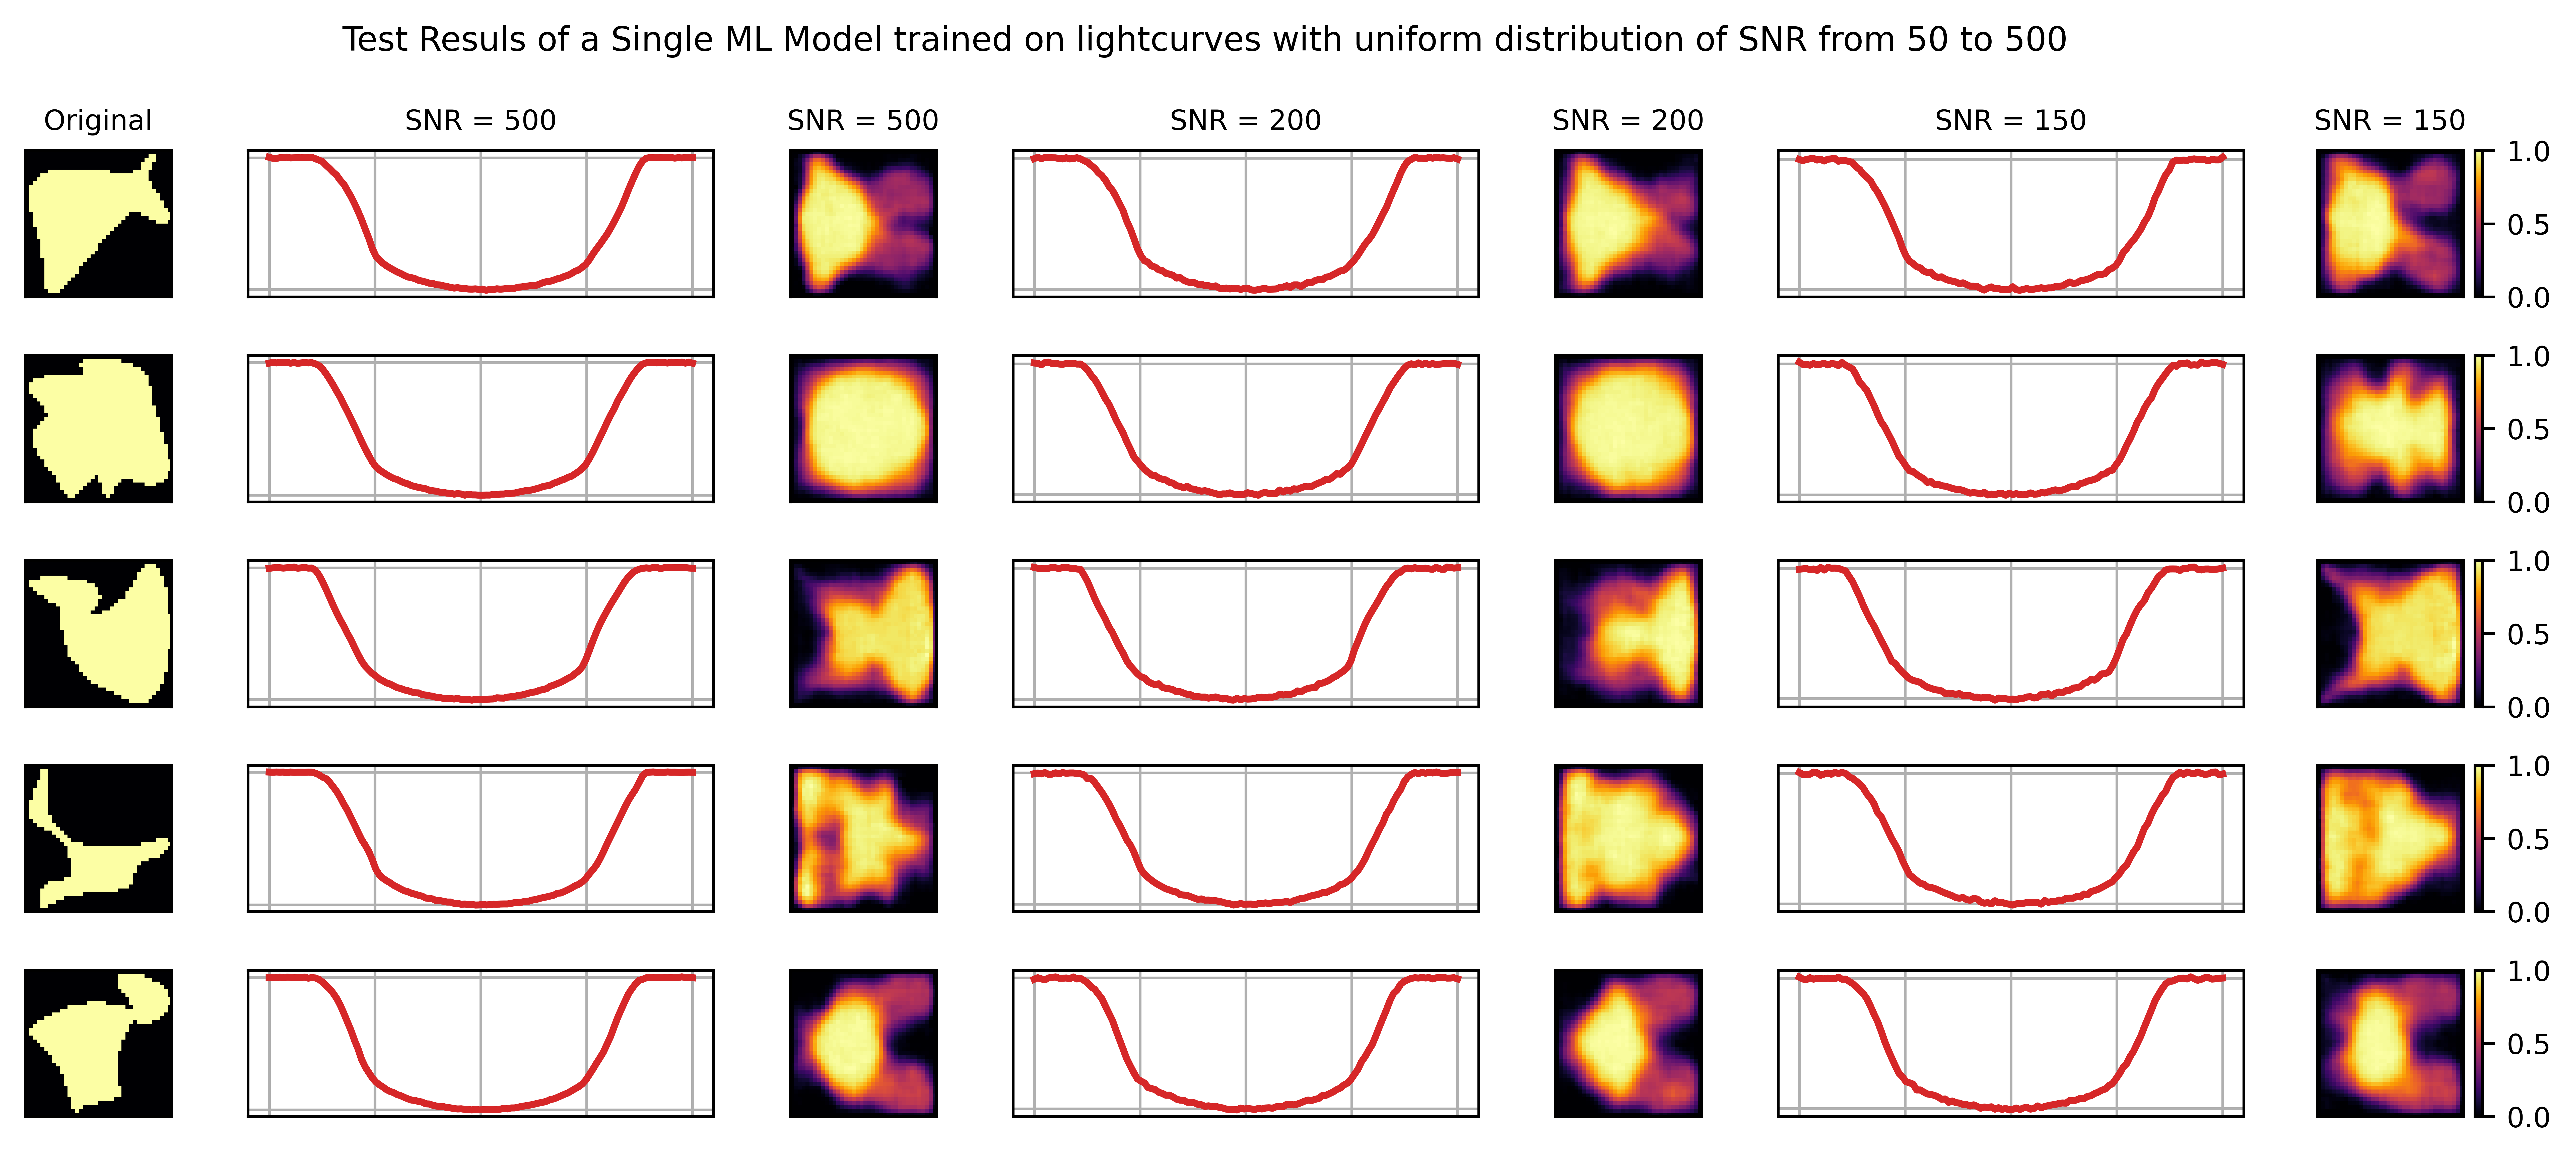

k =  133
k =  128
k =  172
k =  155
k =  223


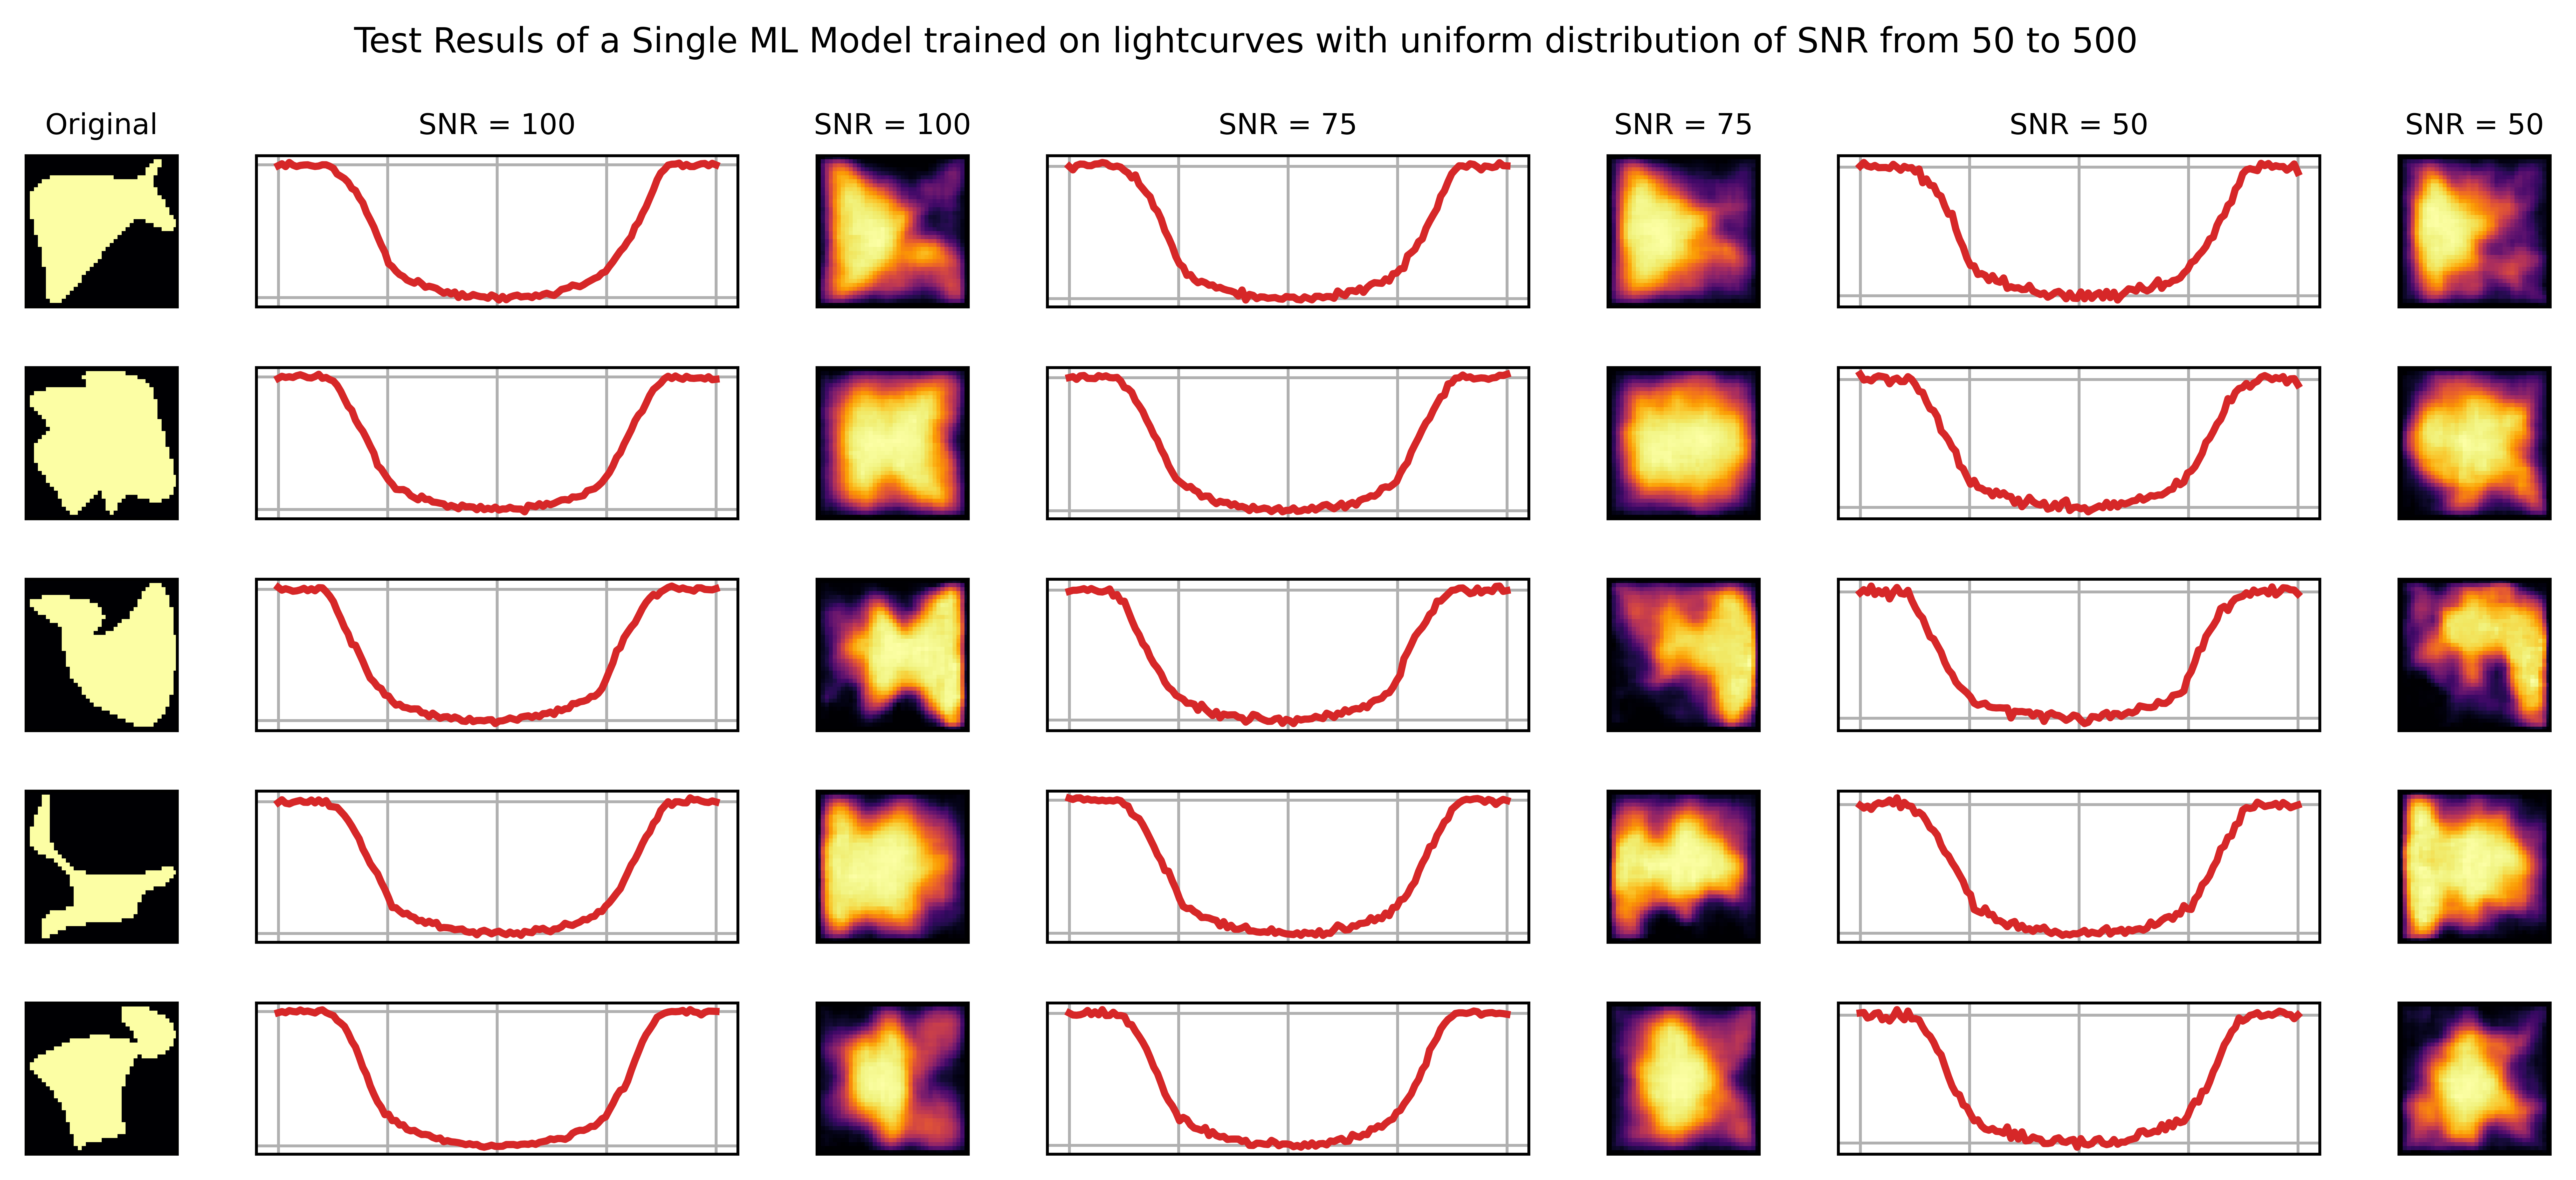

In [12]:
# Plot predicted shapes
num = 5
fig,ax=plt.subplots(num,7, figsize=(13,5), gridspec_kw={ 'width_ratios': [1,2,1,2,1,2,1],
        'wspace': 0.1,'hspace': 0.4})
plt.rcParams['figure.dpi'] = 1000
plt.rcParams.update({'font.size': 8})

ax[0][0].set_title('Original',size=8)
ax[0][1].set_title('SNR = 500',size=8)
ax[0][2].set_title('SNR = 500',size=8)
ax[0][3].set_title('SNR = 200',size=8)
ax[0][4].set_title('SNR = 200',size=8)
ax[0][5].set_title('SNR = 150',size=8)
ax[0][6].set_title('SNR = 150',size=8)

temp = np.linspace(0, len(test_lc_scaled_append)-1,len(test_lc_scaled_append))
index_test_array = np.random.choice(temp, size=(num,), replace=False)

for i in range(num):
    k =  int(index_test_array[i]) # random.randint(0, len(test_lc_scaled_append)-1) # i
    print("k = ",k)
    ax[i][0].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][3].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][4].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][5].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][6].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)

    img = ax[i][0].imshow(test_shape[k],cmap='inferno')
    # plt.colorbar(img)  

    ax[i][1].plot(ph, test_lc_SNR500[k],color = 'tab:red',linewidth='2')
    ax[i][1].grid('on')

    img = ax[i][2].imshow(test_predict_shape_SNR500[k],cmap='inferno')
    # plt.colorbar(img)  

    ax[i][3].plot(ph, test_lc_SNR200[k],color = 'tab:red',linewidth='2')
    ax[i][3].grid('on')

    img = ax[i][4].imshow(test_predict_shape_SNR200[k],cmap='inferno')
    # plt.colorbar(img)   

    ax[i][5].plot(ph, test_lc_SNR150[k],color = 'tab:red',linewidth='2')
    ax[i][5].grid('on')

    img = ax[i][6].imshow(test_predict_shape_SNR150[k],cmap='inferno')
    plt.colorbar(img)    


plt.suptitle('Test Resuls of a Single ML Model trained on lightcurves with uniform distribution of SNR from 50 to 500')
plt.show()
# Plot predicted shapes
num = 5
fig,ax=plt.subplots(num,7, figsize=(13,5), gridspec_kw={ 'width_ratios': [1,2,1,2,1,2,1],
        'wspace': 0.1,'hspace': 0.4})
plt.rcParams['figure.dpi'] = 1000
plt.rcParams.update({'font.size': 8})

ax[0][0].set_title('Original',size=8)
ax[0][1].set_title('SNR = 100',size=8)
ax[0][2].set_title('SNR = 100',size=8)
ax[0][3].set_title('SNR = 75',size=8)
ax[0][4].set_title('SNR = 75',size=8)
ax[0][5].set_title('SNR = 50',size=8)
ax[0][6].set_title('SNR = 50',size=8)


# temp = np.linspace(0, len(test_lc_scaled_append)-1,len(test_lc_scaled_append))
# index_test_array = np.random.choice(temp, size=(num,), replace=False)

for i in range(num):
    k =  int(index_test_array[i]) # random.randint(0, len(test_lc_scaled_append)-1) # i
    print("k = ",k)
    ax[i][0].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][3].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][4].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][5].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][6].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)

    img = ax[i][0].imshow(test_shape[k],cmap='inferno')
    # plt.colorbar(img)  

    ax[i][1].plot(ph, test_lc_SNR100[k],color = 'tab:red',linewidth='2')
    ax[i][1].grid('on')

    img = ax[i][2].imshow(test_predict_shape_SNR100[k],cmap='inferno')
    # plt.colorbar(img)  

    ax[i][3].plot(ph, test_lc_SNR75[k],color = 'tab:red',linewidth='2')
    ax[i][3].grid('on')

    img = ax[i][4].imshow(test_predict_shape_SNR75[k],cmap='inferno')
    # plt.colorbar(img)   

    ax[i][5].plot(ph, test_lc_SNR50[k],color = 'tab:red',linewidth='2')
    ax[i][5].grid('on')

    img = ax[i][6].imshow(test_predict_shape_SNR50[k],cmap='inferno')
    # plt.colorbar(img)     

plt.suptitle('Test Resuls of a Single ML Model trained on lightcurves with uniform distribution of SNR from 50 to 500')
plt.show()

k =  202
k =  66
k =  43
k =  102
k =  216


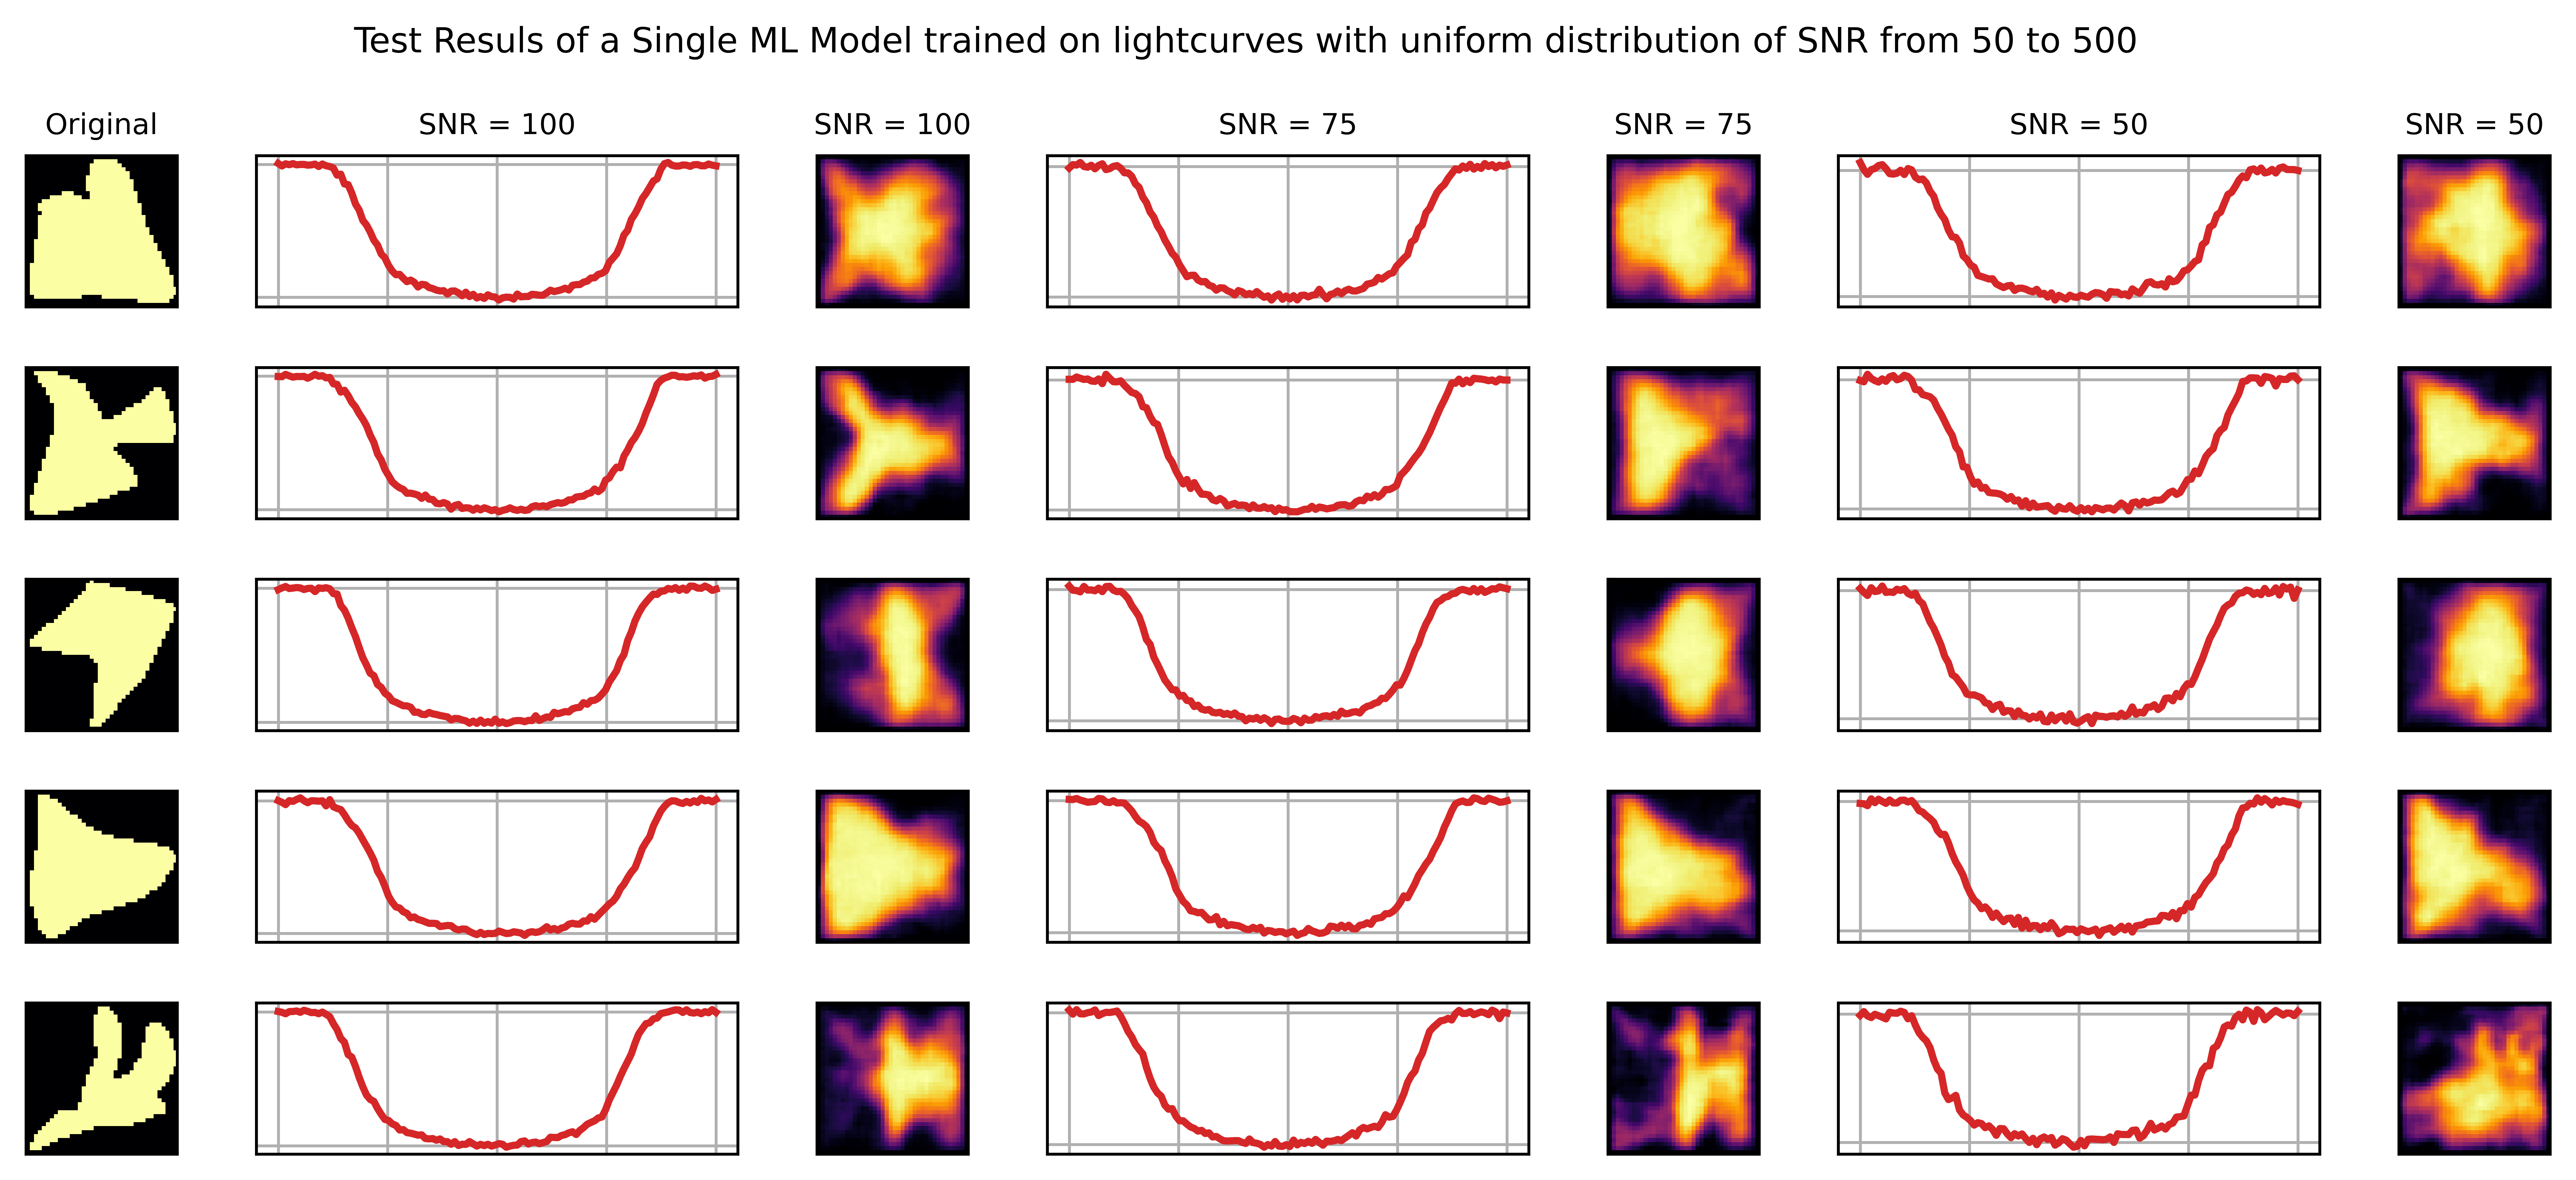

In [13]:
# Plot predicted shapes
num = 5
fig,ax=plt.subplots(num,7, figsize=(13,5), gridspec_kw={ 'width_ratios': [1,2,1,2,1,2,1],
        'wspace': 0.1,'hspace': 0.4})
plt.rcParams['figure.dpi'] = 1000
plt.rcParams.update({'font.size': 8})

ax[0][0].set_title('Original',size=8)
ax[0][1].set_title('SNR = 100',size=8)
ax[0][2].set_title('SNR = 100',size=8)
ax[0][3].set_title('SNR = 75',size=8)
ax[0][4].set_title('SNR = 75',size=8)
ax[0][5].set_title('SNR = 50',size=8)
ax[0][6].set_title('SNR = 50',size=8)


temp = np.linspace(0, len(test_lc_scaled_append)-1,len(test_lc_scaled_append))
index_test_array = np.random.choice(temp, size=(num,), replace=False)

for i in range(num):
    k =  int(index_test_array[i]) # random.randint(0, len(test_lc_scaled_append)-1) # i
    print("k = ",k)
    ax[i][0].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][3].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][4].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][5].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][6].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)

    img = ax[i][0].imshow(test_shape[k],cmap='inferno')
    # plt.colorbar(img)  

    ax[i][1].plot(ph, test_lc_SNR100[k],color = 'tab:red',linewidth='2')
    ax[i][1].grid('on')

    img = ax[i][2].imshow(test_predict_shape_SNR100[k],cmap='inferno')
    # plt.colorbar(img)  

    ax[i][3].plot(ph, test_lc_SNR75[k],color = 'tab:red',linewidth='2')
    ax[i][3].grid('on')

    img = ax[i][4].imshow(test_predict_shape_SNR75[k],cmap='inferno')
    # plt.colorbar(img)   

    ax[i][5].plot(ph, test_lc_SNR50[k],color = 'tab:red',linewidth='2')
    ax[i][5].grid('on')

    img = ax[i][6].imshow(test_predict_shape_SNR50[k],cmap='inferno')
    # plt.colorbar(img)     

plt.suptitle('Test Resuls of a Single ML Model trained on lightcurves with uniform distribution of SNR from 50 to 500')
plt.show()